In [1]:
! pip install contractions
!pip  install pyspellchecker
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
import string
from IPython.display import clear_output
from nltk.tokenize import sent_tokenize
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
nltk.download('stopwords')
nltk.download('vader_lexicon')
import contractions
from collections import Counter
from matplotlib import pyplot as plt
from matplotlib import ticker
import seaborn as sns
import plotly.express as px
import nltk
nltk.download('punkt')
nltk.download('wordnet')
sns.set(style="darkgrid")
clear_output()
color_map = {'negative': '#f0543c',
             'neutral': '#08cc94',
             'positive': '#686cfc'}

In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/gabrielpreda/covid-19-tweets/master/covid19_tweets.csv")

In [3]:
data.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,False
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,False
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False


#Feature Engineering

In [4]:
data['user_location'] = data['user_location'].replace({'New Delhi, India': 'India', 'Mumbai, India': 'India'})
data['user_location'] = data['user_location'].replace({'London, England': 'United Kingdom', 'London': 'United Kingdom'})
data['user_location'] = data['user_location'].replace({'Washington, DC': 'United States','New York, NY': 'United States'})
data['user_location'] = data['user_location'].str.replace(r'\bUSA\b', 'United States', regex=True)
data['user_location'] = data['user_location'].str.replace(r'\bUK\b', 'United Kingdom', regex=True)

location_mapping = {
    'Geneva, Switzerland': 'Switzerland',
    'Seattle, WA': 'United States',
    'Sydney, New South Wales': 'Australia',
    'Philadelphia, PA': 'United States',
    'Las Vegas, NV': 'United States',
    'Washington, D.C.': 'United States',
    'New York City': 'United States',
    'Los Angeles': 'United States',
    'Texas': 'United States',
    'Planet Earth': 'Worldwide',
    'Ontario, Canada': 'Canada',
    'Cape Town, South Africa': 'South Africa',
    'Guwahati, India': 'India',
    'NYC': 'New York, United States',
    'Jammu And Kashmir': 'India',
    'Abuja, Nigeria': 'Nigeria',
    'Europe': 'European Union',
    'Malaysia': 'Kuala Lumpur, Malaysia',
    'Bangalore': 'Bengaluru, India',
    'Nairobi': 'Kenya',
    'Dubai, United Arab Emirates': 'Dubai, UAE',
    'Odisha': 'India',
    'Dublin City, Ireland': 'Dublin, Ireland',
    'Canberra': 'Australia',
    'Pune, India': 'India',
    'England': 'United Kingdom',
    'United Arab Emirates': 'UAE',
    'California': 'California, United States',
    'Hyderabad': 'Hyderabad, India',
    'New Zealand': 'Wellington, New Zealand',
    '#AFRICA #MENA': 'Africa',
    'Melbourne': 'Melbourne, Australia',
    'Florida': 'Florida, United States',
    'Dublin, Ireland': 'Dublin, Ireland',
    'Chicago': 'Chicago, IL, United States',
    'Paris, France': 'Paris, France',
    'Brooklyn, NY': 'Brooklyn, New York, United States',
    'Pretoria, South Africa': 'Pretoria, South Africa',
    'Baltimore, MD': 'Baltimore, MD, United States',
    'Jaipur, India': 'Jaipur, India',
    'Kampala, Uganda': 'Kampala, Uganda',
    'Brussels, Belgium': 'Brussels, Belgium',
    'Bangkok, Thailand': 'Bangkok, Thailand',
    'Sydney': 'Sydney, Australia',
    'Sri Lanka': 'Colombo, Sri Lanka'

}



data['user_location'].value_counts()[0:4]



user_location
India             6863
United States     5708
United Kingdom    4381
Australia          964
Name: count, dtype: int64

In [5]:
print(data.shape)
print(data.columns)

(179108, 13)
Index(['user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'text', 'hashtags', 'source', 'is_retweet'],
      dtype='object')


In [6]:
needed_columns = ['user_name','user_location', 'date', 'text','user_verified','user_followers']
df = data[needed_columns]
df.head()

,user_name,user_location,date,text,user_verified,user_followers
0,ᏉᎥ☻լꂅϮ,astroworld,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,False,624
1,Tom Basile 🇺🇸,United States,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,True,2253
2,Time4fisticuffs,"Pewee Valley, KY",2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,False,9275
3,ethel mertz,Stuck in the Middle,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,False,197
4,DIPR-J&K,Jammu and Kashmir,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,False,101009


In [7]:
print(df.isnull().sum())

user_name             0
user_location     36771
date                  0
text                  0
user_verified         0
user_followers        0
dtype: int64


In [8]:
df.user_name = df.user_name.astype('category')
df.user_verified = df.user_verified.astype('category')
df.user_name = df.user_name.cat.codes
df['date'] = pd.to_datetime(df['date'])
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].dt.date
clear_output()
df.dtypes

user_name            int32
user_location       object
date                object
text                object
user_verified     category
user_followers       int64
dtype: object

#Data visualization


In [9]:
top_locations = data['user_location'].value_counts().head(4).reset_index()
top_locations.columns = ['user_location', 'count']

fig = px.bar(top_locations,
             x='user_location',
             y='count',
             color='user_location',
             title='Tweets in Top 4 Cities')

fig.show()

In [10]:
data['date'] = pd.to_datetime(data['date'])
top_locations_over_time = data.groupby(['user_location', pd.Grouper(key='date', freq='D')]).size().reset_index(name='count')
top_4_locations = top_locations_over_time.groupby('user_location')['count'].sum().nlargest(4).index

top_locations_over_time_filtered = top_locations_over_time[top_locations_over_time['user_location'].isin(top_4_locations)]

fig = px.line(top_locations_over_time_filtered,
              x='date',
              y='count',
              color='user_location',
              title='Tweets Over Time in Top 4 Cities')

fig.show()

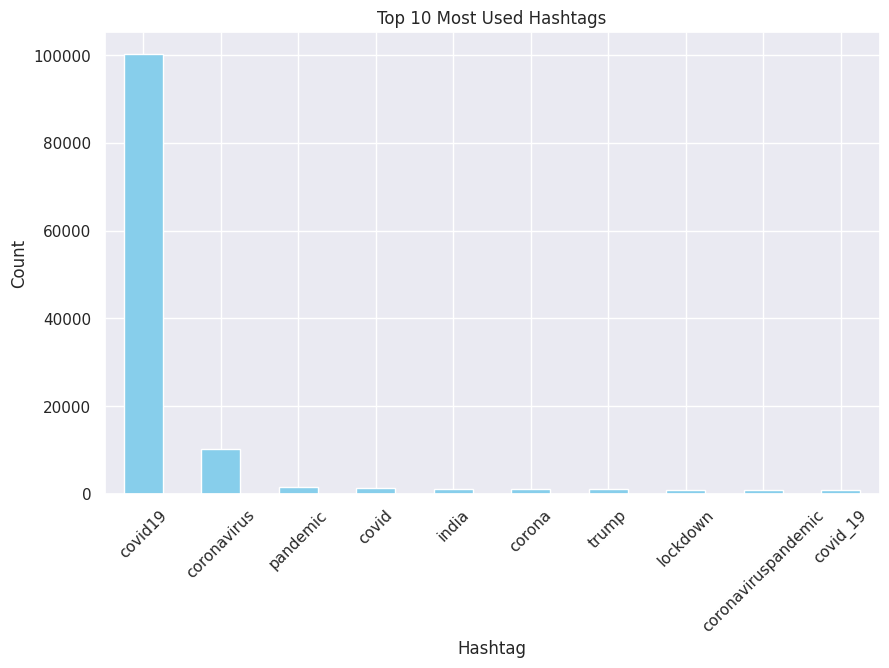

In [11]:
hashtags = data['text'].apply(lambda x: re.findall(r'#(\w+)', x))
hashtags_flat = [tag.lower() for sublist in hashtags for tag in sublist]
hashtags_counts = pd.Series(hashtags_flat).value_counts().head(10)  # Change '10' to the desired number of top hashtags
plt.figure(figsize=(10, 6))
hashtags_counts.plot(kind='bar', color='skyblue')
plt.title('Top 10 Most Used Hashtags')
plt.xlabel('Hashtag')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [12]:
df.head(3)

,user_name,user_location,date,text,user_verified,user_followers
0,89755,astroworld,2020-07-25,If I smelled the scent of hand sanitizers toda...,False,624
1,76403,United States,2020-07-25,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,True,2253
2,76147,"Pewee Valley, KY",2020-07-25,@diane3443 @wdunlap @realDonaldTrump Trump nev...,False,9275


In [13]:
texts = df['text']
texts

0         If I smelled the scent of hand sanitizers toda...
1         Hey @Yankees @YankeesPR and @MLB - wouldn't it...
2         @diane3443 @wdunlap @realDonaldTrump Trump nev...
3         @brookbanktv The one gift #COVID19 has give me...
4         25 July : Media Bulletin on Novel #CoronaVirus...
                                ...                        
179103    Thanks @IamOhmai for nominating me for the @WH...
179104    2020! The year of insanity! Lol! #COVID19 http...
179105    @CTVNews A powerful painting by Juan Lucena. I...
179106    More than 1,200 students test positive for #CO...
179107    I stop when I see a Stop\n\n@SABCNews\n@Izinda...
Name: text, Length: 179108, dtype: object

#Data Preprocessing

In [14]:
stop_words = set(stopwords.words('english'))
more_words = ['covid','coronavirus','covid19']
mention_pattern = r'@[\w]+'
stop_words.update(more_words)
remove_words = lambda x : ' '.join([word for word in x.split() if word not in stop_words])
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    words = nltk.word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)


def preprocess(text: str):
    text = text.lower() # Hello --> hello
    text = re.sub(r'https?\S+', '', text)     # Remove URLs
    text= re.sub(r'@[\w]+', '', text) # remove menthions ---> Hello @faris ---> Hello
    text = re.sub(r'<[^>]+>', '', text) # remove !@#$%^&*()_=+
    text = contractions.fix(text) # i'm --> i am
    text = re.sub(r'[^a-zA-Z]', ' ', text) # hello فارس ---> hello
    text = re.sub(r'(.)\1+', r'\1', text) # likkkkke --> like
    tokens = word_tokenize(text) # i am faris --> {i,am,faris}
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]
    preprocessed_text = ' '.join(lemmatized_tokens)
    return preprocessed_text

In [15]:
textPro = texts.apply(preprocess)
words_list = [word for line in textPro for word in line.split()]


In [16]:
word_counts = Counter(words_list).most_common(10)
words_df = pd.DataFrame(word_counts)
words_df.columns = ['word', 'frq']
words_df.head()

,word,frq
0,case,21035
1,new,15081
2,amp,12908
3,wil,10715
4,death,10433


In [17]:
px.bar(words_df, x='word', y='frq', title='Most Common Words in tweets', labels={'word': 'Word', 'frq': 'Frequency'})

In [18]:
df.text = textPro
df.head()

<ipython-input-18-a59fe51f96bd>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,user_name,user_location,date,text,user_verified,user_followers
0,89755,astroworld,2020-07-25,smeled scent hand sanitizers today someone pas...,False,624
1,76403,United States,2020-07-25,hey would made sense player pay respect,True,2253
2,76147,"Pewee Valley, KY",2020-07-25,trump never claimed hoax claim efort,False,9275
3,84572,Stuck in the Middle,2020-07-25,one gift give apreciation simple thing always ...,False,197
4,18398,Jammu and Kashmir,2020-07-25,july medium buletin novel coronavirusupdates,False,101009


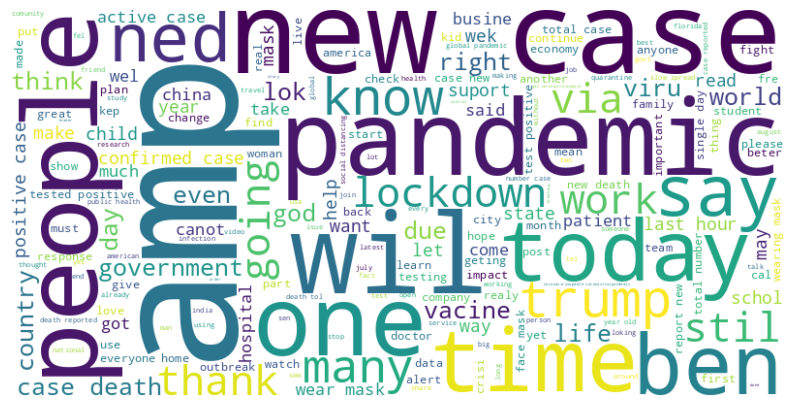

In [19]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(textPro))
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#Data Modeling

In [20]:
sid = SentimentIntensityAnalyzer() # >> pos neu neg
ps = lambda x : sid.polarity_scores(x)
sentiment_scores = df.text.apply(ps)
sentiment_scores

0         {'neg': 0.0, 'neu': 0.738, 'pos': 0.262, 'comp...
1         {'neg': 0.147, 'neu': 0.526, 'pos': 0.326, 'co...
2         {'neg': 0.0, 'neu': 0.734, 'pos': 0.266, 'comp...
3         {'neg': 0.0, 'neu': 0.707, 'pos': 0.293, 'comp...
4         {'neg': 0.0, 'neu': 0.635, 'pos': 0.365, 'comp...
                                ...                        
179103    {'neg': 0.0, 'neu': 0.58, 'pos': 0.42, 'compou...
179104    {'neg': 0.493, 'neu': 0.133, 'pos': 0.373, 'co...
179105    {'neg': 0.29, 'neu': 0.484, 'pos': 0.226, 'com...
179106    {'neg': 0.0, 'neu': 0.625, 'pos': 0.375, 'comp...
179107    {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound...
Name: text, Length: 179108, dtype: object

In [21]:
sentiment_df = pd.DataFrame(data=list(sentiment_scores))
sentiment_df.head()

,neg,neu,pos,compound
0,0.000,0.738,0.262,0.4939
1,0.147,0.526,0.326,0.4019
2,0.000,0.734,0.266,0.2057
3,0.000,0.707,0.293,0.4404
4,0.000,0.635,0.365,0.3182


In [22]:
labelize = lambda x : 'neutral' if x==0 else ('positive' if x> 0 else 'negative')
sentiment_df['label'] = sentiment_df.compound.apply(labelize)
sentiment_df.head()

,neg,neu,pos,compound,label
0,0.000,0.738,0.262,0.4939,positive
1,0.147,0.526,0.326,0.4019,positive
2,0.000,0.734,0.266,0.2057,positive
3,0.000,0.707,0.293,0.4404,positive
4,0.000,0.635,0.365,0.3182,positive


In [23]:
df=df.join(sentiment_df.label)

In [24]:
df.head()

,user_name,user_location,date,text,user_verified,user_followers,label
0,89755,astroworld,2020-07-25,smeled scent hand sanitizers today someone pas...,False,624,positive
1,76403,United States,2020-07-25,hey would made sense player pay respect,True,2253,positive
2,76147,"Pewee Valley, KY",2020-07-25,trump never claimed hoax claim efort,False,9275,positive
3,84572,Stuck in the Middle,2020-07-25,one gift give apreciation simple thing always ...,False,197,positive
4,18398,Jammu and Kashmir,2020-07-25,july medium buletin novel coronavirusupdates,False,101009,positive


#Result Visualization

In [25]:
positive_freq = df[df['label'] == 'positive']['text'].str.split(expand=True).stack().value_counts()
negative_freq = df[df['label'] == 'negative']['text'].str.split(expand=True).stack().value_counts()

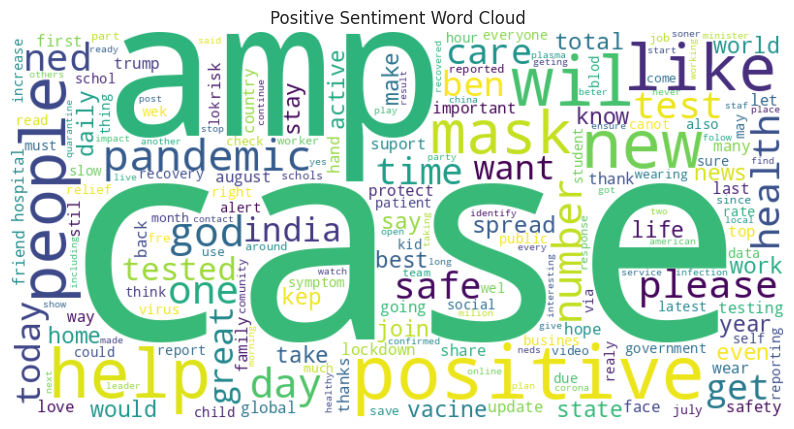

In [26]:
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(positive_freq)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Positive Sentiment Word Cloud')
plt.axis('off')
plt.show()

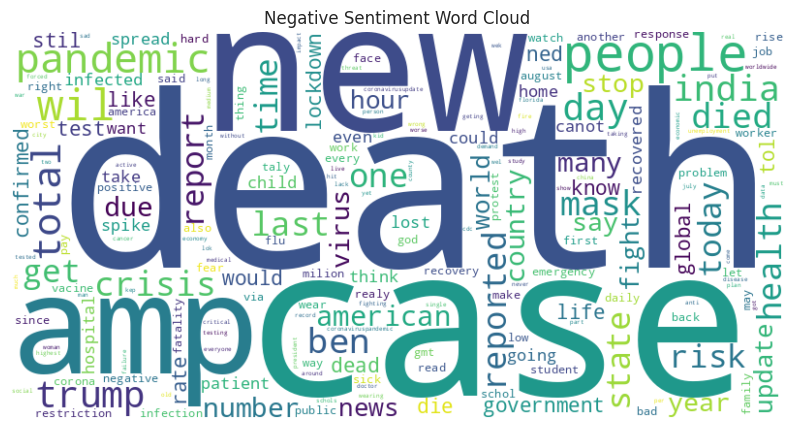

In [27]:
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(negative_freq)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Negative Sentiment Word Cloud')
plt.axis('off')
plt.show()


In [28]:
counts_df = sentiment_df.label.value_counts().reset_index()
counts_df.columns = ['label', 'counts']
counts_df

,label,counts
0,positive,65178
1,neutral,64323
2,negative,49607


<Axes: xlabel='label', ylabel='counts'>

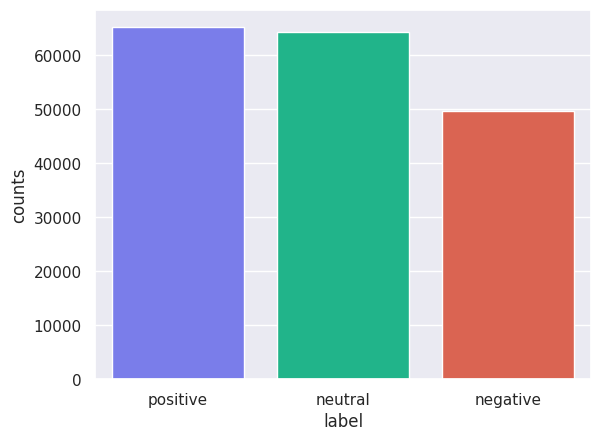

In [29]:
sns.barplot(x='label', y='counts', hue='label', data=counts_df, palette=color_map, legend=False)

In [30]:
data_agg0 = df[['user_name', 'user_verified', 'label']].groupby(['user_verified', 'label']).count().reset_index()
data_agg0.columns = ['user_verified', 'label', 'counts']
data_agg0 = data_agg0.iloc[3:]

fig = px.bar(data_agg0, x='label', y='counts', color='label', title='Sentiment Labels for Verified Users',color_discrete_map=color_map)
fig.show()


In [31]:
data_agg = df[['user_name', 'date', 'label']].groupby(['date', 'label']).count().reset_index()
data_agg.columns = ['date', 'label', 'counts']
data_agg.head()

,date,label,counts
0,2020-07-24,negative,86
1,2020-07-24,neutral,95
2,2020-07-24,positive,114
3,2020-07-25,negative,4582
4,2020-07-25,neutral,5978


In [32]:
px.line(data_agg, x='date', y='counts', color='label', title='Daily Tweets Sentimental Analysis',color_discrete_map=color_map)

In [37]:
top_5_cities_names = df['user_location'].value_counts().index[:4].tolist()
most_common_cities_df = df[df['user_location'].isin(top_5_cities_names)].reset_index(drop=True)

In [35]:
import plotly.express as px
data_agg2 = most_common_cities_df[['user_name', 'user_location', 'label']].groupby(['user_location', 'label']).size().reset_index(name='count')
fig = px.bar(data_agg2, x='user_location', y='count', color='label', title='Sentiment Analysis of Daily Tweets in Top 5 Cities',color_discrete_map=color_map)
fig.show()
